## Imports

In [5]:
# general libraries
import os
import pathlib
import posixpath
import json
import re

In [ ]:
# !pip install bertopic 
# in powershell under book env for local (no need to install again)

In [6]:
# BERTopic libraries
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

#in powershell, pip install tf-keras (no need to install again)

## Data processing

In [7]:
# import and Create new folder
import os
# from google.colab import files (i am using local computing)
import shutil

# new_folder = "Scenario_1" 

# if os.path.isdir(new_folder):
#   shutil.rmtree(new_folder)

# os.mkdir(new_folder)

# Upload Files (i am using local computing and thus code below is unncessary)
# uploaded = files.upload()
# for filename in uploaded.keys():
#   dst_path = os.path.join(new_folder, filename)
#   print(f'move {filename} to {dst_path}')
#   shutil.move(filename, dst_path)

In [8]:
def divide_year_month(data_path, month):

    dir_path=data_path
    month_list=[]
    pattern = re.compile(r"ParlaMint-IT_\d{4}-((0[1-9]|1[0-2]))-\d{2}-LEG\d+-Senato-sed-\d+\.txt")
    for file in sorted(os.listdir(dir_path)):
        res = re.match(pattern, file)
        if res == None:
            pass
        elif res.group(1) == month:
            month_list.append(file)

    return month_list

def divide_year_quarters(data_path):

    dir_path=data_path
    Q1 = []
    Q2 = []
    Q3 = []
    Q4 = []
    pattern = re.compile(r"ParlaMint-IT_\d{4}-((01|02|03)|(04|05|06)|(07|08|09)|(10|11|12))-\d{2}-[A-Z]{3,}\d{1,}-[A-Za-z]+-[a-z]{3}-\d{1,}\.txt")
    for file in sorted(os.listdir(dir_path)):
        res = re.match(pattern, file)
        if res.group(1) in ("01", "02", "03"):
            Q1.append(file)
        elif res.group(1) in ("04", "05", "06"):
            Q2.append(file)
        elif res.group(1) in ("07", "08", "09"):
            Q3.append(file)
        else:
            Q4.append(file)

    return Q1, Q2, Q3, Q4

def read_data(path, month):
    data = divide_year_month(path, month)
    documents = []
    for document in data:
        data_path = posixpath.join(path, document)
        with open(data_path, 'r', encoding='utf-8') as f:
        # Iterate directly over the file object - memory efficient
            for line in f:
                # .strip() removes leading/trailing whitespace, including the newline
                #cleaned_line = line.strip()
                # You now have a clean string for this line

                # You can append the cleaned line to a list if you need all lines first,
                # or process it directly here for the LLM.
                documents.append(line)
    return documents

In [9]:
path = './Scenario_1/Italy_Translated_2021/'
data = divide_year_month(path, "01")
lines = read_data(path, "01")

In [10]:
data 
# check the data is read in

['ParlaMint-IT_2021-01-12-LEG18-Senato-sed-290.txt',
 'ParlaMint-IT_2021-01-13-LEG18-Senato-sed-291.txt',
 'ParlaMint-IT_2021-01-14-LEG18-Senato-sed-292.txt',
 'ParlaMint-IT_2021-01-19-LEG18-Senato-sed-293.txt',
 'ParlaMint-IT_2021-01-20-LEG18-Senato-sed-294.txt',
 'ParlaMint-IT_2021-01-26-LEG18-Senato-sed-295.txt',
 'ParlaMint-IT_2021-01-27-LEG18-Senato-sed-296.txt']

In [11]:
lines
# check the conent of the file

['The sitting was opened at 4.33 p.m. The Minutes were read. The minutes of the sitting of 30 December 2020 shall be read. TOSATO, Secretary, read the Minutes of the sitting of 30 December 2020. THE PRESIDENT. - As there are no observations, the Minutes are approved. In the absence of any comments, the Minutes shall be approved.\n',
 "The list of Senators on leave and absenteeism received by the Senate, as well as further communications to the Assembly, will be published in Annex B to the minutes of today's sitting.\n",
 'I would like to inform the House that at the beginning of the sitting the Chairman of the Five Star Movement sent a request for an electronic vote under Rule 113 (2) for all the votes to be taken during the sitting.\n',
 '\n',
 '                  \n',
 'Honourable senators, I would like to express my heartfelt thoughts of closeness and condolences to the family, colleagues and friends of Senator Emilia Grazia De Biasi. A woman of brilliant intelligence and inexhaustib

## Process Data

In [12]:
# Step 1. remove the "\n" from every line
processed_lines = [line.strip("\n") for line in lines]
len(processed_lines)

# Step 2. remove the lines with fewer than 10 words.
processed_lines_test = [ ]
for line in processed_lines:
    if len(line.split()) < 15:
        pass
    else:
        processed_lines_test.append(line)
len(processed_lines_test)

1547

In [52]:
# further DATA CLEANING
import re
def clean_speech_lines(lines):
    processed_lines = []
    for line in lines:
        line = line.strip()   # Strip whitespace and newline chars
        line = re.sub(r'\s+', ' ', line) # Remove multiple spaces or tabs inside lines
        line = re.sub(r'[^\w\s]', '', line) # remove non-standard characters or punctuation if needed
        line = line.lower() # lowercase everything

        if len(line.split()) >= 15:
            processed_lines.append(line)
    return processed_lines
processed_lines_test = clean_speech_lines(lines)
print(len(processed_lines_test))


1544


In [ ]:
processed_lines_test

['the sitting was opened at 433 pm the minutes were read the minutes of the sitting of 30 december 2020 shall be read tosato secretary read the minutes of the sitting of 30 december 2020 the president  as there are no observations the minutes are approved in the absence of any comments the minutes shall be approved',
 'the list of senators on leave and absenteeism received by the senate as well as further communications to the assembly will be published in annex b to the minutes of todays sitting',
 'i would like to inform the house that at the beginning of the sitting the chairman of the five star movement sent a request for an electronic vote under rule 113 2 for all the votes to be taken during the sitting',
 'honourable senators i would like to express my heartfelt thoughts of closeness and condolences to the family colleagues and friends of senator emilia grazia de biasi a woman of brilliant intelligence and inexhaustible energy emilia de biasi has been a genuine protagonist of na

## BERTopic

In [54]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  language = "multilingual",
  min_topic_size=20,
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
)

In [55]:
topics, probs = topic_model.fit_transform(processed_lines_test)

In [56]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,571,-1_parliament_vote_speech_members,"[parliament, vote, speech, members, ministers,...",[let us restore the credibility of the institu...
1,0,168,0_political_parliament_politics_ministers,"[political, parliament, politics, ministers, r...",[de bertoldi fdi it mr president although tod...
2,1,121,1_presidentinoffice_speech_political_politics,"[presidentinoffice, speech, political, politic...",[i want to tell you president that you have sh...
3,2,82,2_senate_politician_senator_political,"[senate, politician, senator, political, polit...",[grassi lsppsdaz it mr president ladies and g...
4,3,67,3_convened_committees_parliamentary_meeting,"[convened, committees, parliamentary, meeting,...",[the sitting was opened at 433 pm the minutes ...
5,4,61,4_parliament_policy_law_responsibility,"[parliament, policy, law, responsibility, work...",[steger svppatt uv nl mr president ladies and...
6,5,59,5_coercion_government_conspiracies_dictatorship,"[coercion, government, conspiracies, dictators...",[the authorisation of the moderna vaccine alon...
7,6,58,6_parliament_national_restrictions_unprecedented,"[parliament, national, restrictions, unprecede...",[you mr minister are well aware that this viru...
8,7,50,7_government_objective_minister_citizens,"[government, objective, minister, citizens, pa...",[the parliament is also considering the family...
9,8,50,8_protesting_debate_colleagues_consideration,"[protesting, debate, colleagues, consideration...",[salvini lsppsdaz words and music by beppe gri...


In [57]:
topic_model.get_representative_docs()

{-1: ['let us restore the credibility of the institutions we represent let us try to give full meaning and depth to the words we cant even consider the function of the minister as in fact something to do with the chair please lets go back to the meaning of the words the minister like a teacher from the word magister or a doctor represents the identity of a community and the most important and valuable role to safeguard the minister like a teacher from the word magister or a doctor represents the identity of a community and the most important and precious role to be safeguarded let us stop using incomplete terms devoid of any connection with the etymological meaning of the words the minister has the fundamental function of leading the country out of the pandemic and therefore we must represent the dignity of these institutions if we want to offer citizens the credibility and national responsibility which is manifested in this vote today the minister has the fundamental function of leadi

In [58]:
topic_model.visualize_topics()

In [59]:
# tuning BERT Hyperparameters
# Tool: Hugging Face's transformers library with optuna for tuning
# Goal: Maximize coherence of extracted topics

import optuna
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [60]:
import numpy as np
import torch

# adjusted maximum length for truncation
max_length = 50
# take first 100 lines for experiment
shortened_texts = [text[:max_length] for text in texts[:100]]
# example NumPy array (use previous embedding results)
# first load the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# then generate embeddings for shortened texts
my_embeddings = embedding_model.encode(shortened_texts, convert_to_numpy=True)
# covert to Tensor to fix embedding error
tensor_data = torch.from_numpy(my_embeddings)

print("Shortened texts (first 100 lines):", shortened_texts)
print("Converted Tensor:", tensor_data)


Shortened texts (first 100 lines): ['The sitting was opened at 4.33 p.m. The Minutes we', 'The list of Senators on leave and absenteeism rece', 'I would like to inform the House that at the begin', 'Honourable senators, I would like to express my he', 'As President of the Senate Health and Hygiene Comm', 'The same spirit which has supported and guided her', 'In Emilia De Biasi he leaves us a passionate polit', 'Remembering his figure and his tireless civil and ', 'In memory of Senator Emilia Grazia De Biasi, I the', 'Mr President, I would like to thank you for your w', 'LANIECE (Aut (SVP-PATT, UV)). Mr President, I met ', 'PRESIDENT. - The next item is the report (Doc. Mr ', 'LAFORGIA (Misto-LeU). Mr President, it is very pai', 'RIZZOTTI (FIBP-UDC). - (IT) It is with great regre', 'I think we need to make an effort on this, giving ', "RIVOLTA (L-SP-PSd'Az). - (IT) Mr President, I cann", 'PELLEGRINI MARCO (M5S). - (IT) Mr President, Senat', 'The Conference of Heads of State or Governmen

In [61]:
# dummy labels. labels were not created in the previous steps. 
# here, try an unsupervised task, using embeddings for clustering, e.g., kmeans to explore the data structure without labels
# objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_clusters = trial.suggest_int("n_clusters", 2, 10)  # Number of clusters to try
    max_iter = trial.suggest_int("max_iter", 100, 300)  # Max iterations for k-means

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=42)
    cluster_labels = kmeans.fit_predict(my_embeddings)

    # Use silhouette score as the metric to maximize (higher is better)
    from sklearn.metrics import silhouette_score
    score = silhouette_score(my_embeddings, cluster_labels)
    return -score  # Minimize negative silhouette score (Optuna minimizes by default)

# run optimization
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)  # Adjust n_trials as needed

print("Best trial parameters:", study.best_params)
print("Best trial value (negative silhouette score):", study.best_value)

[I 2025-08-05 14:58:43,556] A new study created in memory with name: no-name-385f46ab-e376-4c66-bd9f-bff2bc176498
[I 2025-08-05 14:58:43,571] Trial 0 finished with value: -0.037554867565631866 and parameters: {'n_clusters': 5, 'max_iter': 189}. Best is trial 0 with value: -0.037554867565631866.
[I 2025-08-05 14:58:43,585] Trial 1 finished with value: -0.04306614771485329 and parameters: {'n_clusters': 10, 'max_iter': 166}. Best is trial 1 with value: -0.04306614771485329.
[I 2025-08-05 14:58:43,596] Trial 2 finished with value: -0.05920979380607605 and parameters: {'n_clusters': 4, 'max_iter': 257}. Best is trial 2 with value: -0.05920979380607605.
[I 2025-08-05 14:58:43,607] Trial 3 finished with value: -0.037554867565631866 and parameters: {'n_clusters': 5, 'max_iter': 235}. Best is trial 2 with value: -0.05920979380607605.
[I 2025-08-05 14:58:43,619] Trial 4 finished with value: -0.05920979380607605 and parameters: {'n_clusters': 4, 'max_iter': 190}. Best is trial 2 with value: -0.0

Best trial parameters: {'n_clusters': 2, 'max_iter': 106}
Best trial value (negative silhouette score): -0.08088788390159607


when n_trials = 10, best trial parameters: {'n_clusters': 3, 'max_iter': - 0.06849293410778046} 
thus, a wider range (increased n_trials) but the silhouette score worsened -- the clustering quality has decreased 
in the next step, try a refined range (2-20) and 30 trials

In [62]:
from sentence_transformers import SentenceTransformer
import optuna
from sklearn.cluster import KMeans

def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 20)  
    max_iter = trial.suggest_int("max_iter", 100, 300) 

    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=42)
    cluster_labels = kmeans.fit_predict(my_embeddings)

    from sklearn.metrics import silhouette_score
    score = silhouette_score(my_embeddings, cluster_labels)
    return -score

study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30) 

[I 2025-08-05 14:58:54,261] A new study created in memory with name: no-name-6832375a-ef7a-46c8-9459-113c0e2e2ee8
[I 2025-08-05 14:58:54,278] Trial 0 finished with value: -0.049231041222810745 and parameters: {'n_clusters': 11, 'max_iter': 158}. Best is trial 0 with value: -0.049231041222810745.
[I 2025-08-05 14:58:54,289] Trial 1 finished with value: -0.05920979380607605 and parameters: {'n_clusters': 4, 'max_iter': 248}. Best is trial 1 with value: -0.05920979380607605.
[I 2025-08-05 14:58:54,356] Trial 2 finished with value: -0.0892893522977829 and parameters: {'n_clusters': 19, 'max_iter': 141}. Best is trial 2 with value: -0.0892893522977829.
[I 2025-08-05 14:58:54,377] Trial 3 finished with value: -0.07852741330862045 and parameters: {'n_clusters': 16, 'max_iter': 183}. Best is trial 2 with value: -0.0892893522977829.
[I 2025-08-05 14:58:54,390] Trial 4 finished with value: -0.06301288306713104 and parameters: {'n_clusters': 14, 'max_iter': 264}. Best is trial 2 with value: -0.08

the new result with n_trials = 30 shows the best trial (trial 3) with a value of -0.09464597702026367, which is more negative silhouette score 
--> increasing the number of trials to 30 while keeping the n_clusters range at 2-20, did not improvethe clustering quality and may have led to a less optimal configuration
--> BEST parameters:n_clusters = 20, max_iter = 194 (but the silhouette score of -0.09464597702026367 is the most negative so far) -- 20 clusters might be overfitting or that the data does not support such granularity

so far, the highest (least negative) silhouette scores are with fewer clusters: trial 8 (-0.0376, 5 clusters), Trial 1 (-0.0431, 10 clusters), and Trial 18 (-0.0478, 7 clusters). 

the negative scores across all trials indicate that the clusters are not well separated, which could reflect the data's intrinsic structure or the limitations of k-means with this dataset

in the code below, ajust n_clusters range to (2,10) while keep n_trials = 30

In [40]:
def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)  
    max_iter = trial.suggest_int("max_iter", 100, 300) 

    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=42)
    cluster_labels = kmeans.fit_predict(my_embeddings)

    from sklearn.metrics import silhouette_score
    score = silhouette_score(my_embeddings, cluster_labels)
    return -score

study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30) 

[I 2025-08-05 11:07:17,395] A new study created in memory with name: no-name-4f54624f-6677-4773-9b8d-dfa6911910d5
[I 2025-08-05 11:07:17,413] Trial 0 finished with value: -0.08088788390159607 and parameters: {'n_clusters': 2, 'max_iter': 203}. Best is trial 0 with value: -0.08088788390159607.
[I 2025-08-05 11:07:17,427] Trial 1 finished with value: -0.037554867565631866 and parameters: {'n_clusters': 5, 'max_iter': 152}. Best is trial 0 with value: -0.08088788390159607.
[I 2025-08-05 11:07:17,438] Trial 2 finished with value: -0.06849293410778046 and parameters: {'n_clusters': 3, 'max_iter': 154}. Best is trial 0 with value: -0.08088788390159607.
[I 2025-08-05 11:07:17,450] Trial 3 finished with value: -0.06849293410778046 and parameters: {'n_clusters': 3, 'max_iter': 186}. Best is trial 0 with value: -0.08088788390159607.
[I 2025-08-05 11:07:17,465] Trial 4 finished with value: -0.04826684296131134 and parameters: {'n_clusters': 9, 'max_iter': 145}. Best is trial 0 with value: -0.0808

Now, the highest silhouette score is -0.037554867565631866 from Trials 1, 20, and 26, all with n_clusters = 5, and max_iter values of 152, 255, and 185, respectively. --> 5 clusters provide the best separation among the trials. 
In the next step, try n_clusters = 5 or 6 and tune other parameters 

In [41]:
def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 4, 7)  # Narrowed to 4-7 based on results
    max_iter = trial.suggest_int("max_iter", 100, 300)

    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=42)
    cluster_labels = kmeans.fit_predict(my_embeddings)

    from sklearn.metrics import silhouette_score
    score = silhouette_score(my_embeddings, cluster_labels)

    return score

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

print("Best trial parameters:", study.best_params)
print("Best trial value (silhouette score):", study.best_value)

[I 2025-08-05 11:24:18,620] A new study created in memory with name: no-name-f3e1e0ac-1d2b-499e-b83f-44a23d203ab2
[I 2025-08-05 11:24:18,636] Trial 0 finished with value: 0.037554867565631866 and parameters: {'n_clusters': 5, 'max_iter': 192}. Best is trial 0 with value: 0.037554867565631866.
[I 2025-08-05 11:24:18,649] Trial 1 finished with value: 0.03975405544042587 and parameters: {'n_clusters': 6, 'max_iter': 270}. Best is trial 1 with value: 0.03975405544042587.
[I 2025-08-05 11:24:18,661] Trial 2 finished with value: 0.03975405544042587 and parameters: {'n_clusters': 6, 'max_iter': 150}. Best is trial 1 with value: 0.03975405544042587.
[I 2025-08-05 11:24:18,672] Trial 3 finished with value: 0.037554867565631866 and parameters: {'n_clusters': 5, 'max_iter': 259}. Best is trial 1 with value: 0.03975405544042587.
[I 2025-08-05 11:24:18,684] Trial 4 finished with value: 0.03975405544042587 and parameters: {'n_clusters': 6, 'max_iter': 111}. Best is trial 1 with value: 0.039754055440

Best trial parameters: {'n_clusters': 4, 'max_iter': 238}
Best trial value (silhouette score): 0.05920979380607605


° 4 clusters is the most stable and best performing configuration
° increasing max_tier did not significantly affet clustering performance
° the clustering space is likely not strongly structured (common in high-dimensional NLP data)

-- before going further, i'd like to first visualize the results

In [45]:
from sentence_transformers import SentenceTransformer
import pandas as pd 

topics, _ = topic_model.fit_transform(shortened_texts)

# get embeddings using the same model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(shortened_texts, show_progress_bar=True)

df = pd.DataFrame({
    "text": shortened_texts,
    "topic": topics
})
df["embedding"] = embeddings.tolist()

df.to_json("cluster_data.json", orient="records")


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

the above code worked on shortened_texts. later, i tried original texts and it also worked well. 

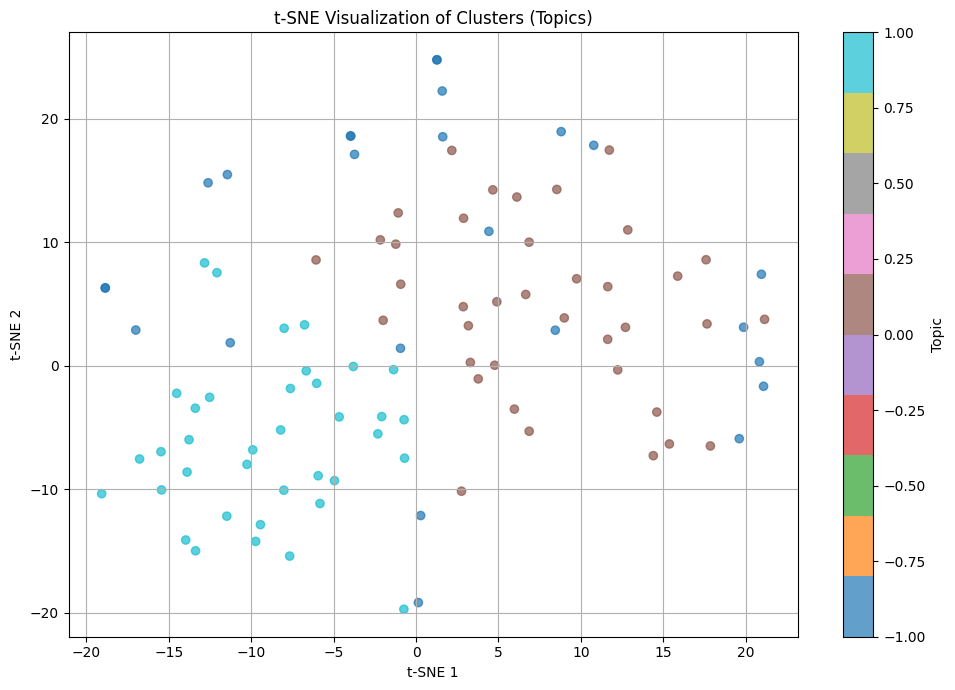

In [46]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

with open("cluster_data.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

embeddings = np.array(df["embedding"].tolist())
topics = df["topic"]

scaled_embeddings = StandardScaler().fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=15, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(scaled_embeddings)

df["tsne_1"] = tsne_results[:, 0]
df["tsne_2"] = tsne_results[:, 1]

plt.figure(figsize=(10, 7))
scatter = plt.scatter(df["tsne_1"], df["tsne_2"], c=topics, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Topic")
plt.title("t-SNE Visualization of Clusters (Topics)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


kmeans gave low-quality clusters. now, try HDBSCAN
(with the hope to uncover cleaner, more meaningful groupings)

In [63]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# generate embeddings in the same way
max_length = 50
shortened_texts = [text[:max_length] for text in texts[:100]]
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
my_embeddings = embedding_model.encode(shortened_texts, convert_to_numpy=True)


In [64]:
import hdbscan
import numpy as np

clusterer =  hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels = clusterer.fit_predict(my_embeddings)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)
print(f"Found {n_clusters} clusters with {n_noise} noise points.")

Found 0 clusters with 100 noise points.


this could be due to the limited dataset/short text. 
now, try full dataset

In [65]:
full_texts = processed_lines_test
full_embeddings = embedding_model.encode(full_texts, convert_to_numpy=True, show_progress_bar=True)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric='euclidean')
labels = clusterer.fit_predict(full_embeddings)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)
print(f"Found {n_clusters} clusters with {n_noise} noise points.")

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Found 24 clusters with 1086 noise points.


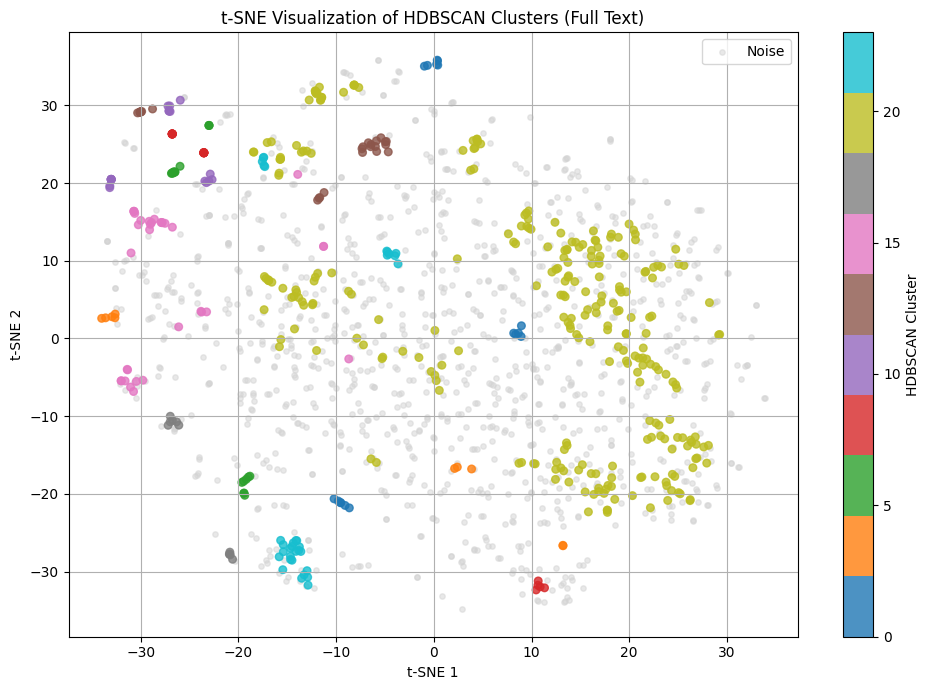

In [66]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Scale embeddings before t-SNE
scaled_embeddings= StandardScaler().fit_transform(full_embeddings)

# compute tsne projection
tsne = TSNE(n_components=2, perplexity=15, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(scaled_embeddings)

# create masks for clustered vs. noise points
labels = np.array(labels)
mask_noise = labels == -1
mask_clustered = ~mask_noise

plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[mask_noise, 0], tsne_results[mask_noise, 1],
            color='lightgray', label='Noise', alpha=0.5, s=15)

scatter = plt.scatter(tsne_results[mask_clustered, 0], tsne_results[mask_clustered, 1],
                      c=labels[mask_clustered], cmap="tab10", alpha=0.8, s=30)

plt.colorbar(scatter, label="HDBSCAN Cluster")
plt.title("t-SNE Visualization of HDBSCAN Clusters (Full Text)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# EXPLORE cluster contents
# preview cluster contents - excluding noise

from collections import defaultdict

cluster_docs = defaultdict(list)

for i, label in enumerate(labels):
    if label != -1:
        cluster_docs[label].append(full_texts[i])

# print 1-2 sample docs per cluster
for cluster_id, docs in cluster_docs.items():
    print(f"\n🔹 Cluster {cluster_id} — {len(docs)} docs")
    print("Sample 1:", docs[0][:200], "...")
    if len(docs) > 1:
        print("Sample 2:", docs[1][:200], "...")
        



🔹 Cluster 6 — 11 docs
Sample 1: the sitting was opened at 433 pm the minutes were read the minutes of the sitting of 30 december 2020 shall be read tosato secretary read the minutes of the sitting of 30 december 2020 the president   ...
Sample 2: i would like to inform the presidency that the opinion of the fifth standing committee on this bill has been received and is being circulated ...

🔹 Cluster 8 — 7 docs
Sample 1: the list of senators on leave and absenteeism received by the senate as well as further communications to the assembly will be published in annex b to the minutes of todays sitting ...
Sample 2: the list of senators on leave and absenteeism received by the senate as well as further communications to the assembly will be published in annex b to the minutes of todays sitting ...

🔹 Cluster 10 — 7 docs
Sample 1: i would like to inform the house that at the beginning of the sitting the chairman of the five star movement sent a request for an electronic vote under rule 113